In [16]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import pycaret.regression as pyr
from sklearn.metrics import mean_absolute_error


In [17]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [18]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
#df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
#df['month'] = df['time'].dt.month


In [19]:
excluded_features_0_10 = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 'temperature', 'original_location']

lags = [24, 25, 26, 48, 49, 50, 72]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'avg_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().mean()
    df[f'std_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().std() 
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag)
    

    if lag < 48:
        excluded_features_11_24.append(f'load_t-{lag}h')
        excluded_features_11_24.append(f'avg_load_t-{lag}h')
        excluded_features_11_24.append(f'std_load_t-{lag}h')
        excluded_features_11_24.append(f'temperature_t-{lag}h')
    


df.dropna(inplace=True)

In [20]:
excluded_features_11_24

['time',
 'temperature',
 'original_location',
 'load_t-24h',
 'avg_load_t-24h',
 'std_load_t-24h',
 'temperature_t-24h',
 'load_t-25h',
 'avg_load_t-25h',
 'std_load_t-25h',
 'temperature_t-25h',
 'load_t-26h',
 'avg_load_t-26h',
 'std_load_t-26h',
 'temperature_t-26h']

In [21]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [22]:
from sklearn.model_selection import train_test_split

def split_train_test_by_location(df, hour_limit=10):
    train_dfs = []
    test_dfs = []
    
    # Filter data based on hour
    if hour_limit == 10:
        df_filtered = df[df['hour'] <= 10].copy()
    else:
        df_filtered = df[df['hour'] > 10].copy()
    
    for location in df_filtered['original_location'].unique():
        location_data = df_filtered[df_filtered['original_location'] == location]
        train_df, test_df = train_test_split(location_data, test_size=0.2, random_state=42)
        train_dfs.append(train_df)
        test_dfs.append(test_df)
    
    # Combine the training data and testing data
    combined_train_df = pd.concat(train_dfs)
    combined_test_df = pd.concat(test_dfs)
    
    return combined_train_df, combined_test_df


In [23]:
def train_and_test_for_location(train_data, test_data, excluded_features):
    results = {}

    for location in train_data['original_location'].unique():
        location_train = train_data[train_data['original_location'] == location]
        location_test = test_data[test_data['original_location'] == location]

        pyr.setup(data=location_train, target='consumption', ignore_features=excluded_features,verbose=False, session_id=42)

        model = pyr.create_model('et')
        #model = pyr.compare_models(sort='mape')
        pyr.plot_model(model, plot='feature')

        predictions = pyr.predict_model(model, data=location_test)

        results[location] = predictions

    return results


In [24]:
train_0_10, test_0_10 = split_train_test_by_location(df, hour_limit=10)
train_11_24, test_11_24 = split_train_test_by_location(df, hour_limit=11)


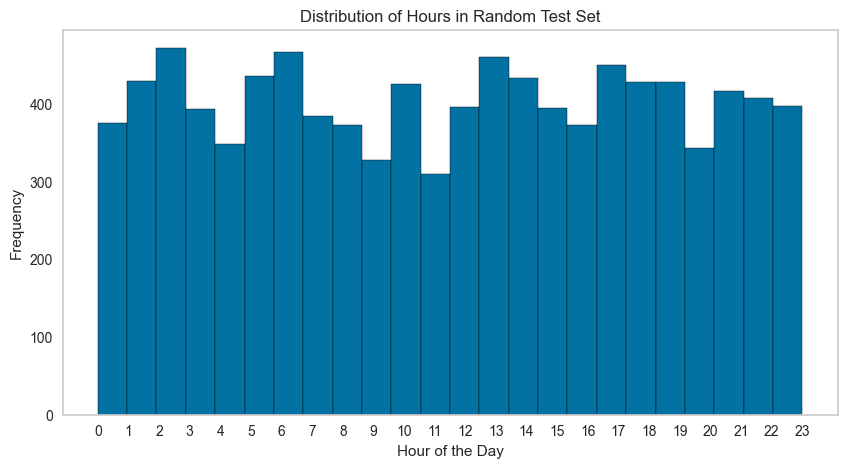

" # Histogram for months\nplt.figure(figsize=(10, 5))\ntest_df['month'].hist(bins=12, edgecolor='black')\nplt.title('Distribution of Months in Random Test Set')\nplt.xlabel('Month')\nplt.ylabel('Frequency')\nplt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])\nplt.grid(False)\nplt.show() "

In [25]:
import matplotlib.pyplot as plt

# Assuming test_df is your random test set
test_df = test_0_10.append(test_11_24)  # Combining both hour ranges for the random test set

# Histogram for hours of the day
plt.figure(figsize=(10, 5))
test_df['hour'].hist(bins=24, edgecolor='black')
plt.title('Distribution of Hours in Random Test Set')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(24))
plt.grid(False)
plt.show()

""" # Histogram for months
plt.figure(figsize=(10, 5))
test_df['month'].hist(bins=12, edgecolor='black')
plt.title('Distribution of Months in Random Test Set')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(False)
plt.show() """


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:46:43
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0576,0.0086,0.0926,0.9929,0.0283,0.0361
1,0.0715,0.0109,0.1044,0.9909,0.0311,0.0436
2,0.0680,0.0094,0.0970,0.9920,0.0286,0.0382
3,0.0586,0.0079,0.0890,0.9931,0.0271,0.0357
4,0.0597,0.0079,0.0890,0.9932,0.0261,0.0329
5,0.0708,0.0155,0.1246,0.9870,0.0334,0.0374
6,0.0612,0.0082,0.0903,0.9930,0.0293,0.0410
7,0.0515,0.0061,0.0780,0.9947,0.0242,0.0328
8,0.0554,0.0065,0.0807,0.9944,0.0255,0.0339


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0561,0.0074,0.0859,0.9938,0.0252,0.0333


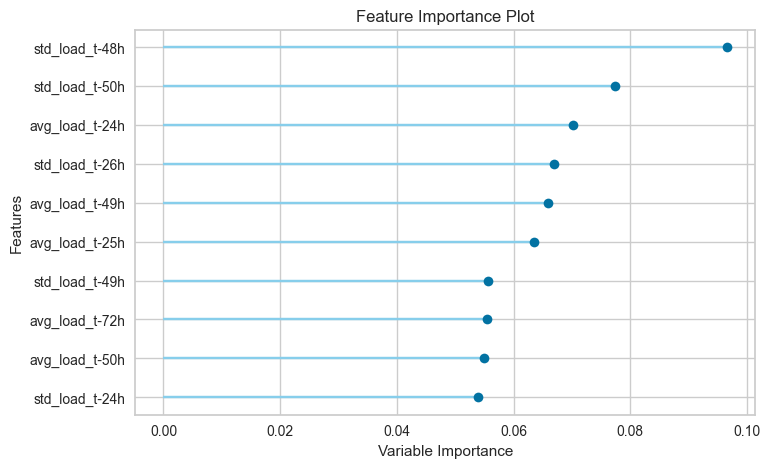

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0561,0.0074,0.0859,0.9938,0.0252,0.0333


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:46:52
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2193,0.1248,0.3533,0.9941,0.0426,0.0379
1,0.2174,0.1284,0.3583,0.9937,0.0390,0.0346
2,0.2034,0.1034,0.3215,0.9948,0.0336,0.0301
3,0.1880,0.0807,0.2840,0.9959,0.0339,0.0316
4,0.2011,0.0856,0.2925,0.9958,0.0320,0.0306
5,0.2226,0.1588,0.3985,0.9926,0.0369,0.0312
6,0.2034,0.1170,0.3420,0.9942,0.0366,0.0330
7,0.1837,0.0926,0.3043,0.9954,0.0325,0.0303
8,0.2178,0.1524,0.3904,0.9924,0.0449,0.0350


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1849,0.0941,0.3067,0.9954,0.0324,0.0299


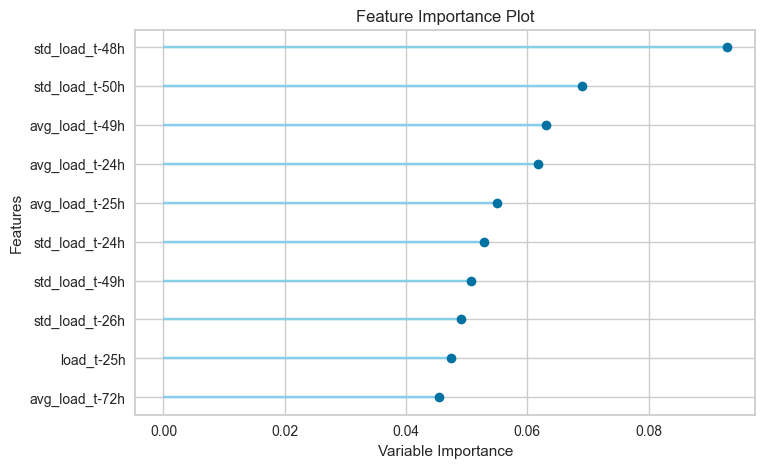

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1849,0.0941,0.3067,0.9954,0.0324,0.0299


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:46:58
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1050,0.0282,0.1680,0.9935,0.0350,0.0363
1,0.1157,0.0344,0.1855,0.9918,0.0363,0.0384
2,0.0944,0.0183,0.1352,0.9956,0.0270,0.0309
3,0.0887,0.0174,0.1318,0.9957,0.0294,0.0321
4,0.1037,0.0241,0.1553,0.9941,0.0298,0.0321
5,0.1099,0.0432,0.2079,0.9900,0.0349,0.0330
6,0.0983,0.0230,0.1517,0.9944,0.0315,0.0351
7,0.0886,0.0198,0.1407,0.9951,0.0289,0.0323
8,0.1041,0.0272,0.1649,0.9933,0.0335,0.0356


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0874,0.0193,0.1389,0.9954,0.0275,0.0304


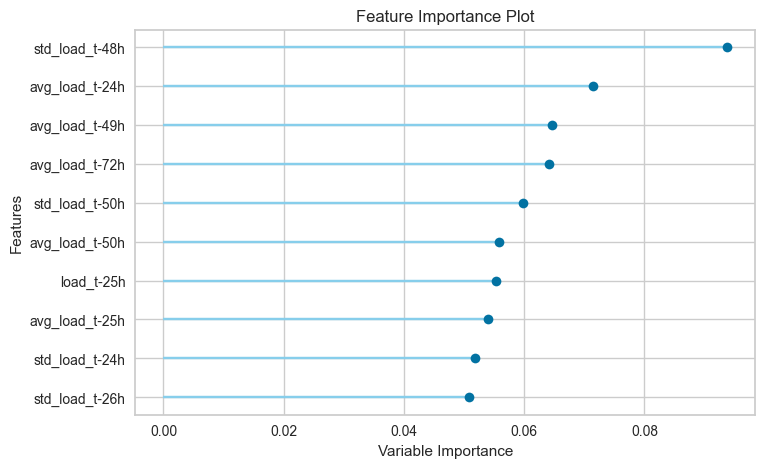

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0874,0.0193,0.1389,0.9954,0.0275,0.0304


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0363,0.0026,0.0512,0.9907,0.0210,0.0313
1,0.0379,0.0027,0.0518,0.9912,0.0213,0.0322
2,0.0405,0.0031,0.0556,0.9891,0.0229,0.0326
3,0.0380,0.0028,0.0534,0.9903,0.0219,0.0305
4,0.0403,0.0034,0.0585,0.9890,0.0231,0.0317
5,0.0409,0.0039,0.0625,0.9872,0.0236,0.0312
6,0.0351,0.0024,0.0490,0.9919,0.0206,0.0301
7,0.0357,0.0026,0.0512,0.9909,0.0207,0.0291
8,0.0355,0.0024,0.0487,0.9918,0.0205,0.0311


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0341,0.0025,0.0497,0.9914,0.0200,0.0282


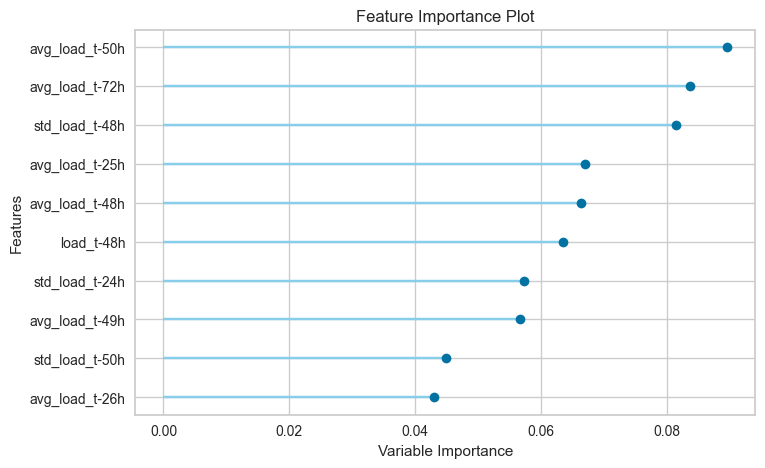

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0341,0.0025,0.0497,0.9914,0.0200,0.0282


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:07
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0781,0.0132,0.1151,0.9883,0.0329,0.0387
1,0.0680,0.0099,0.0994,0.9920,0.0282,0.0341
2,0.0836,0.0157,0.1254,0.9864,0.0342,0.0383
3,0.0714,0.0099,0.0994,0.9913,0.0290,0.0350
4,0.0760,0.0128,0.1132,0.9895,0.0306,0.0346
5,0.0768,0.0156,0.1249,0.9875,0.0309,0.0335
6,0.0730,0.0105,0.1024,0.9912,0.0303,0.0389
7,0.0659,0.0102,0.1011,0.9914,0.0268,0.0309
8,0.0773,0.0134,0.1157,0.9884,0.0319,0.0368


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0696,0.0110,0.1047,0.9908,0.0288,0.0339


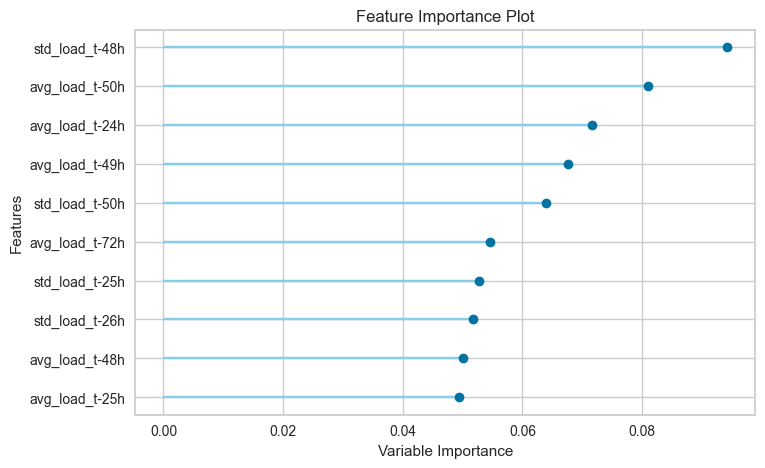

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0696,0.0110,0.1047,0.9908,0.0288,0.0339


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:12
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0424,0.0140,0.1182,0.9502,0.0169,0.0071
1,0.0311,0.0046,0.0680,0.9912,0.0099,0.0052
2,0.0328,0.0049,0.0702,0.9805,0.0096,0.0053
3,0.0451,0.0175,0.1325,0.9482,0.0180,0.0072
4,0.0242,0.0012,0.0348,0.9967,0.0049,0.0040
5,0.0492,0.0190,0.1378,0.9567,0.0198,0.0083
6,0.0385,0.0094,0.0967,0.9710,0.0139,0.0063
7,0.0459,0.0256,0.1599,0.9077,0.0214,0.0072
8,0.0497,0.0212,0.1455,0.9431,0.0210,0.0085


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0362,0.0087,0.0934,0.9669,0.0128,0.0059


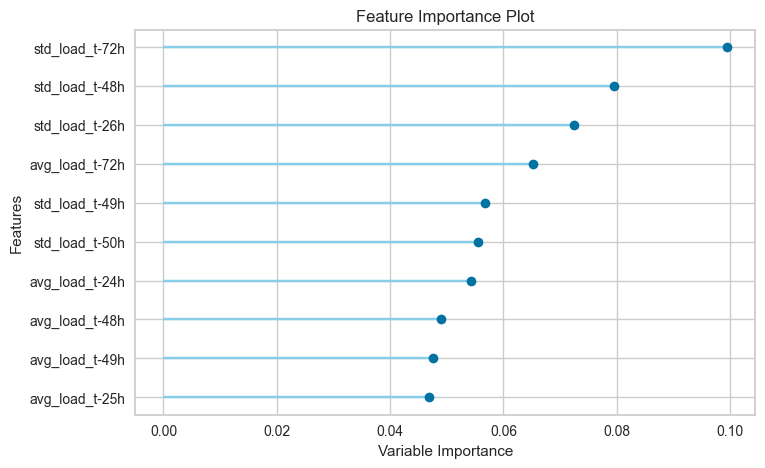

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0362,0.0087,0.0934,0.9669,0.0128,0.0059


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:17
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0644,0.0088,0.0939,0.9942,0.0268,0.0341
1,0.0680,0.0094,0.0972,0.9936,0.0292,0.0384
2,0.0626,0.0082,0.0905,0.9945,0.0275,0.0362
3,0.0612,0.0076,0.0870,0.9943,0.0282,0.0362
4,0.0711,0.0106,0.1032,0.9932,0.0307,0.0403
5,0.0660,0.0099,0.0996,0.9932,0.0288,0.0371
6,0.0618,0.0081,0.0903,0.9946,0.0264,0.0335
7,0.0592,0.0071,0.0843,0.9952,0.0266,0.0354
8,0.0655,0.0095,0.0975,0.9936,0.0285,0.0351


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0623,0.0081,0.0900,0.9944,0.0268,0.0356


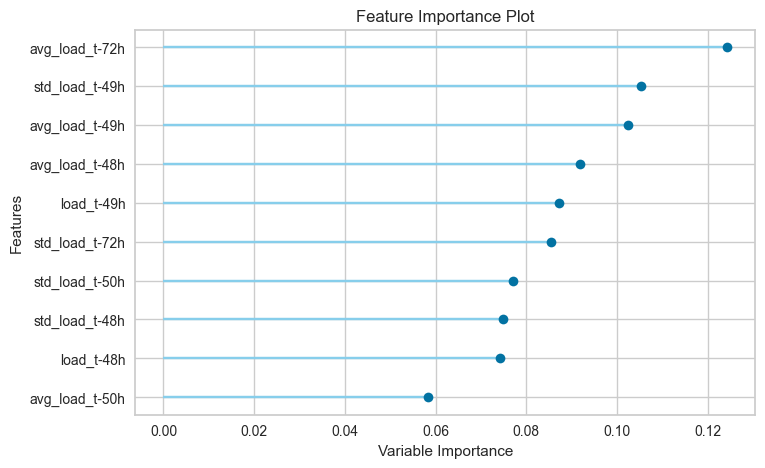

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0623,0.0081,0.0900,0.9944,0.0268,0.0356


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:21
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1863,0.0838,0.2894,0.9964,0.0318,0.0290


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:25
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0995,0.0206,0.1434,0.9957,0.0297,0.0328


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:30
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0360,0.0025,0.0496,0.9924,0.0202,0.0284


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:34
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0689,0.0095,0.0974,0.9930,0.0278,0.0320


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0689,0.0095,0.0974,0.9930,0.0278,0.0320


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:39
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0404,0.0113,0.1065,0.9708,0.0160,0.0070


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
results_0_10 = train_and_test_for_location(train_0_10, test_0_10, excluded_features=excluded_features_0_10)
results_11_24 = train_and_test_for_location(train_11_24, test_11_24,excluded_features=excluded_features_11_24)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(17720, 40)"
4,Transformed data shape,"(17720, 37)"
5,Transformed train set shape,"(12404, 37)"
6,Transformed test set shape,"(5316, 37)"
7,Ignore features,3
8,Numeric features,36
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:47:43
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0949,0.0329,0.1813,0.9962,0.0315,0.0344
1,0.0948,0.0280,0.1674,0.9971,0.0297,0.0332
2,0.0900,0.0308,0.1754,0.9967,0.0316,0.0331
3,0.0958,0.0322,0.1795,0.9963,0.0317,0.0342
4,0.0942,0.0313,0.1769,0.9966,0.0308,0.0346
5,0.0945,0.0310,0.1760,0.9965,0.0329,0.0351
6,0.0955,0.0308,0.1755,0.9967,0.0294,0.0338
7,0.0875,0.0268,0.1636,0.9969,0.0287,0.0324
8,0.0854,0.0289,0.1700,0.9967,0.0294,0.0319


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0848,0.0258,0.1605,0.9971,0.0281,0.0312


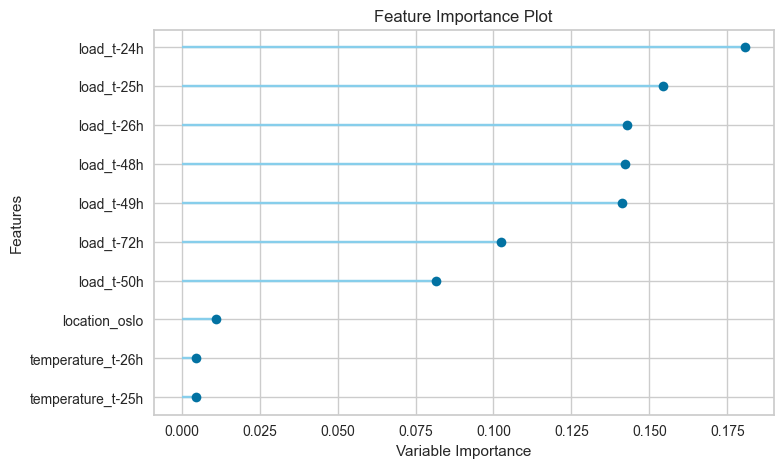

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0848,0.0258,0.1605,0.9971,0.0281,0.0312


In [27]:
pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features_0_10, session_id=42)
best_model_0_10 = pyr.create_model('et')
pyr.plot_model(best_model_0_10, plot='feature')
#best_model_0_10 = pyr.compare_models(sort='mape')
predictions_0_10 = pyr.predict_model(best_model_0_10, data=test_0_10)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(20947, 40)"
4,Transformed data shape,"(20947, 25)"
5,Transformed train set shape,"(14662, 25)"
6,Transformed test set shape,"(6285, 25)"
7,Ignore features,15
8,Numeric features,24
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:48:01
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0990,0.0350,0.1872,0.9967,0.0305,0.0316
1,0.0956,0.0257,0.1602,0.9976,0.0318,0.0342
2,0.1054,0.0344,0.1854,0.9966,0.0330,0.0343
3,0.0962,0.0308,0.1756,0.9970,0.0315,0.0335
4,0.0945,0.0264,0.1625,0.9969,0.0310,0.0330
5,0.1041,0.0353,0.1880,0.9963,0.0315,0.0327
6,0.0966,0.0277,0.1666,0.9974,0.0293,0.0318
7,0.0958,0.0329,0.1813,0.9970,0.0311,0.0322
8,0.0959,0.0295,0.1717,0.9973,0.0359,0.0338


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0916,0.0267,0.1634,0.9973,0.0293,0.0316


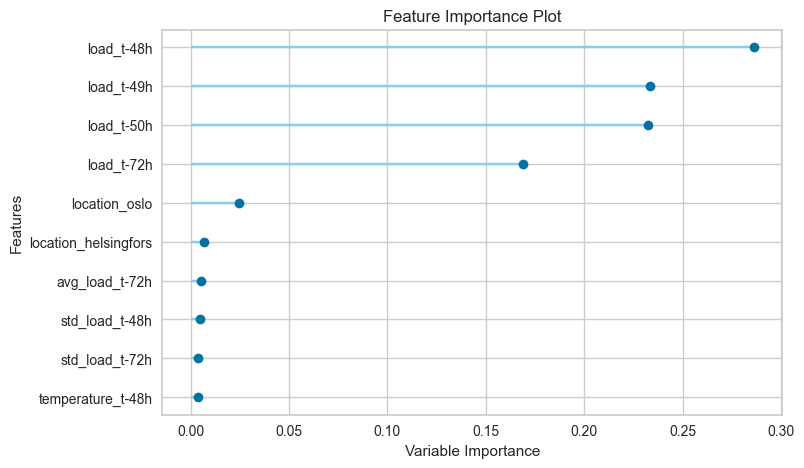

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0916,0.0267,0.1634,0.9973,0.0293,0.0316


In [28]:
pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, session_id=42)
best_model_11_24 = pyr.create_model('et')
#best_model_11_24 = pyr.compare_models('mape')
pyr.plot_model(best_model_11_24, plot='feature')

predictions_11_24 = pyr.predict_model(best_model_11_24, data=test_11_24)


In [29]:
train_0_24 = pd.concat([train_0_10, train_11_24])
test_0_24 = pd.concat([test_0_10, test_11_24])
pyr.setup(data=train_0_24, target='consumption', ignore_features=excluded_features_11_24, session_id=42)
#model = pyr.compare_models(sort='mape')
#best_model_0_24 = pyr.create_model('et')
best_model_0_24 = pyr.compare_models(sort='mape')

#best_model_11_24 = pyr.compare_models('mape')



predictions_0_24 = pyr.predict_model(best_model_0_24, data=test_0_24)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(38667, 40)"
4,Transformed data shape,"(38667, 25)"
5,Transformed train set shape,"(27066, 25)"
6,Transformed test set shape,"(11601, 25)"
7,Ignore features,15
8,Numeric features,24
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:48:15
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0891,0.0262,0.1617,0.9973,0.0290,0.0315,2.2020
rf,Random Forest Regressor,0.1230,0.0507,0.2248,0.9948,0.0384,0.0420,5.9180
dt,Decision Tree Regressor,0.1651,0.1114,0.3328,0.9885,0.0565,0.0562,0.1280
lightgbm,Light Gradient Boosting Machine,0.1550,0.0580,0.2407,0.9940,0.0488,0.0584,1.1410
gbr,Gradient Boosting Regressor,0.2397,0.1635,0.4041,0.9832,0.0702,0.0818,2.0480
knn,K Neighbors Regressor,0.2443,0.1702,0.4123,0.9825,0.0811,0.0928,0.1010
huber,Huber Regressor,0.3442,0.4166,0.6453,0.9572,0.0968,0.1020,0.2830
omp,Orthogonal Matching Pursuit,0.3662,0.4451,0.6670,0.9542,0.1038,0.1153,0.0260
ridge,Ridge Regression,0.3659,0.3965,0.6295,0.9592,0.1064,0.1234,0.0310
br,Bayesian Ridge,0.3660,0.3969,0.6298,0.9592,0.1064,0.1235,0.0590


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0843,0.0223,0.1495,0.9977,0.0274,0.0302


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:50:30
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0543,0.0062,0.0786,0.9952,0.0247,0.0341
1,0.0571,0.0072,0.0850,0.9949,0.0253,0.0328
2,0.0600,0.0076,0.0871,0.9943,0.0265,0.0349
3,0.0613,0.0083,0.0913,0.9935,0.0277,0.0370
4,0.0617,0.0101,0.1004,0.9929,0.0273,0.0329
5,0.0624,0.0085,0.0921,0.9936,0.0268,0.0339
6,0.0629,0.0090,0.0946,0.9933,0.0281,0.0366
7,0.0646,0.0106,0.1027,0.9921,0.0285,0.0360
8,0.0595,0.0080,0.0893,0.9943,0.0272,0.0369


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0559,0.0070,0.0835,0.9948,0.0249,0.0330


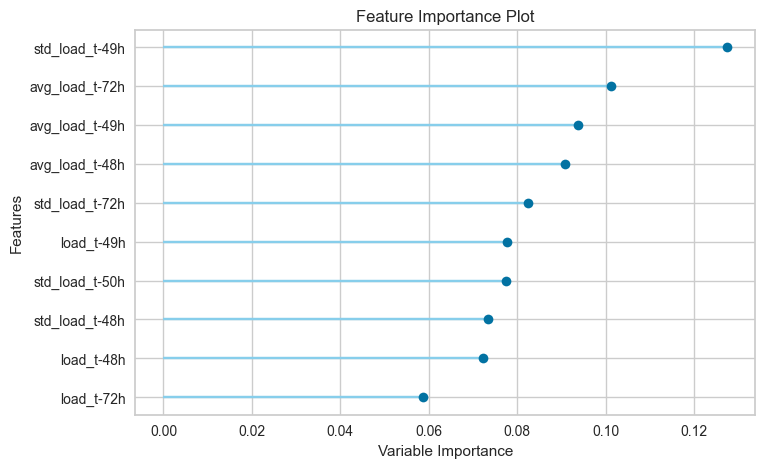

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0559,0.0070,0.0835,0.9948,0.0249,0.0330


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:50:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1735,0.0815,0.2854,0.9961,0.0312,0.0277
1,0.1655,0.0636,0.2522,0.9972,0.0293,0.0269
2,0.1858,0.0782,0.2796,0.9964,0.0308,0.0290
3,0.1714,0.0688,0.2623,0.9967,0.0310,0.0280
4,0.2022,0.1247,0.3531,0.9945,0.0360,0.0304
5,0.1992,0.0987,0.3142,0.9955,0.0337,0.0299
6,0.1902,0.0974,0.3121,0.9956,0.0329,0.0290
7,0.1932,0.1022,0.3197,0.9953,0.0328,0.0292
8,0.1733,0.0683,0.2613,0.9970,0.0320,0.0301


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1699,0.0703,0.2651,0.9968,0.0296,0.0275


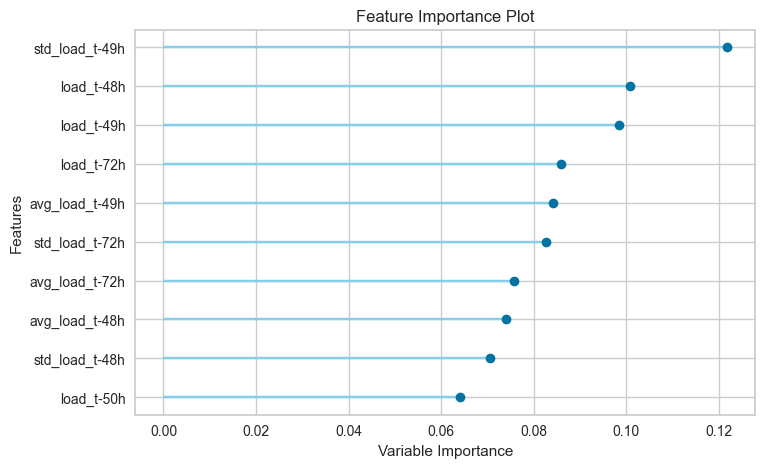

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1699,0.0703,0.2651,0.9968,0.0296,0.0275


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:50:42
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0886,0.0180,0.1343,0.9958,0.0278,0.0302
1,0.0929,0.0198,0.1409,0.9958,0.0283,0.0313
2,0.0905,0.0165,0.1285,0.9963,0.0278,0.0308
3,0.0856,0.0147,0.1214,0.9965,0.0277,0.0313
4,0.0974,0.0235,0.1533,0.9950,0.0293,0.0313
5,0.0981,0.0223,0.1493,0.9950,0.0308,0.0319
6,0.1002,0.0217,0.1474,0.9952,0.0307,0.0328
7,0.0995,0.0253,0.1590,0.9943,0.0302,0.0316
8,0.0854,0.0158,0.1255,0.9966,0.0282,0.0315


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0880,0.0179,0.1340,0.9960,0.0273,0.0303


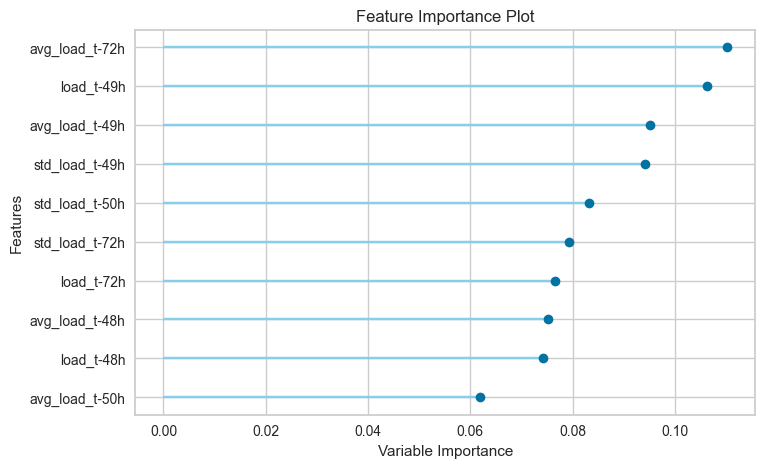

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0880,0.0179,0.1340,0.9960,0.0273,0.0303


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:50:48
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0343,0.0023,0.0480,0.9923,0.0190,0.0269
1,0.0348,0.0023,0.0483,0.9928,0.0199,0.0286
2,0.0336,0.0024,0.0488,0.9924,0.0195,0.0273
3,0.0359,0.0025,0.0503,0.9917,0.0199,0.0280
4,0.0383,0.0028,0.0533,0.9913,0.0209,0.0295
5,0.0363,0.0027,0.0522,0.9918,0.0199,0.0272
6,0.0355,0.0024,0.0494,0.9924,0.0193,0.0276
7,0.0350,0.0028,0.0532,0.9909,0.0205,0.0273
8,0.0336,0.0024,0.0492,0.9926,0.0193,0.0269


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0340,0.0023,0.0478,0.9927,0.0195,0.0276


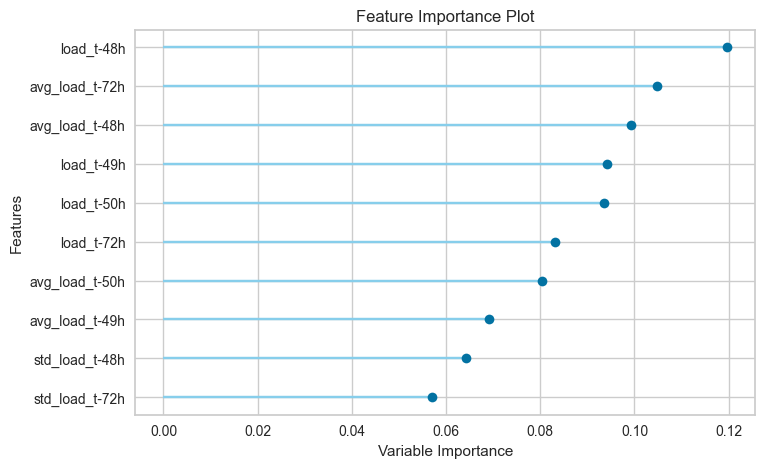

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0340,0.0023,0.0478,0.9927,0.0195,0.0276


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:50:55
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0675,0.0098,0.0990,0.9919,0.0268,0.0316
1,0.0700,0.0106,0.1029,0.9922,0.0270,0.0313
2,0.0683,0.0095,0.0976,0.9927,0.0277,0.0320
3,0.0666,0.0089,0.0945,0.9929,0.0261,0.0312
4,0.0736,0.0118,0.1084,0.9914,0.0277,0.0312
5,0.0662,0.0090,0.0949,0.9933,0.0264,0.0300
6,0.0663,0.0094,0.0969,0.9928,0.0267,0.0306
7,0.0755,0.0131,0.1143,0.9900,0.0301,0.0340
8,0.0701,0.0102,0.1009,0.9926,0.0284,0.0341


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0664,0.0098,0.0991,0.9924,0.0269,0.0309


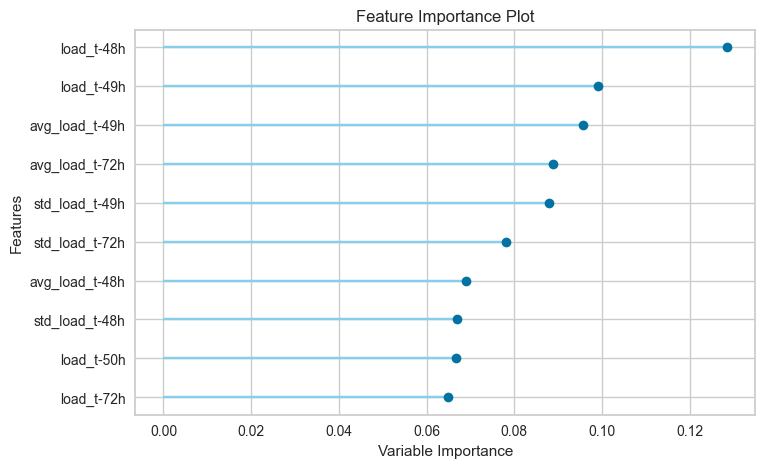

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0664,0.0098,0.0991,0.9924,0.0269,0.0309


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:51:01
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0258,0.0027,0.0518,0.9927,0.0072,0.0042
1,0.0351,0.0080,0.0893,0.9742,0.0126,0.0057
2,0.0351,0.0129,0.1135,0.9614,0.0159,0.0058
3,0.0360,0.0141,0.1188,0.9631,0.0176,0.0061
4,0.0384,0.0092,0.0958,0.9626,0.0137,0.0063
5,0.0422,0.0106,0.1032,0.9798,0.0146,0.0070
6,0.0456,0.0260,0.1612,0.9420,0.0246,0.0082
7,0.0386,0.0155,0.1246,0.9374,0.0174,0.0063
8,0.0470,0.0154,0.1242,0.9634,0.0178,0.0077


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0354,0.0084,0.0918,0.9745,0.0128,0.0058


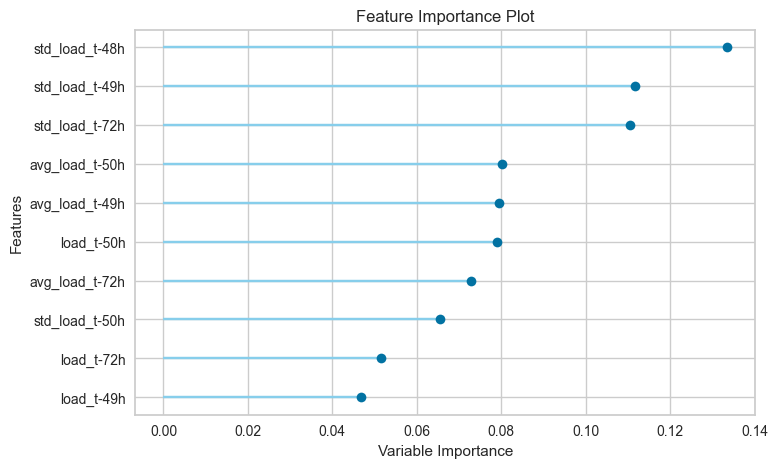

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0354,0.0084,0.0918,0.9745,0.0128,0.0058


In [30]:
results_0_24 = train_and_test_for_location(train_0_24, test_0_24, excluded_features=excluded_features_11_24)


In [31]:
def calculate_mape(true_values, predicted_values):
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100


In [32]:
# Calculate MAPE for training on the entire dataset (for hours 0-10 and 11-24)
# Combine test data and predictions for both hour ranges
combined_test = pd.concat([test_0_10, test_11_24])
combined_predictions_entire = pd.concat([predictions_0_10, predictions_11_24])

# Calculate MAPE for training on the entire dataset for each location
mape_entire_by_location = {}
for location in combined_test['original_location'].unique():
    true_values = combined_test[combined_test['original_location'] == location]['consumption']
    predicted_values = combined_predictions_entire[combined_predictions_entire['original_location'] == location]['prediction_label']
    mape_entire_by_location[location] = calculate_mape(true_values, predicted_values)

# Calculate total MAPE for training on individual locations for each location
mape_individual_by_location = {}
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    mape_individual_by_location[location] = calculate_mape(combined_true, combined_predicted)

# Print MAPE values
print("MAPE for training on entire dataset by location:")
for location, mape in mape_entire_by_location.items():
    print(f"{location}: {mape:.2f}%")

print("\nMAPE for training on individual locations by location:")
for location, mape in mape_individual_by_location.items():
    print(f"{location}: {mape:.2f}%")

# Calculate and print MAPE for the entire dataset for both training methods
mape_entire_total = calculate_mape(combined_test['consumption'], combined_predictions_entire['prediction_label'])
combined_true_individual = pd.concat([results_0_10[loc]['consumption'] for loc in results_0_10.keys()] + [results_11_24[loc]['consumption'] for loc in results_11_24.keys()])
combined_predicted_individual = pd.concat([results_0_10[loc]['prediction_label'] for loc in results_0_10.keys()] + [results_11_24[loc]['prediction_label'] for loc in results_11_24.keys()])
mape_individual_total = calculate_mape(combined_true_individual, combined_predicted_individual)

print("\nMAPE for the entire dataset:")
print(f"Training on entire dataset: {mape_entire_total:.2f}%")
print(f"Training on individual locations: {mape_individual_total:.2f}%")


MAPE for training on entire dataset by location:
bergen: 3.98%
oslo: 3.13%
stavanger: 3.52%
tromsø: 3.15%
trondheim: 3.76%
helsingfors: 0.60%

MAPE for training on individual locations by location:
bergen: 3.45%
oslo: 2.95%
stavanger: 3.17%
tromsø: 2.83%
trondheim: 3.29%
helsingfors: 0.65%

MAPE for the entire dataset:
Training on entire dataset: 3.14%
Training on individual locations: 2.82%


In [33]:
mape_entire_0_24 = calculate_mape(test_0_24['consumption'], predictions_0_24['prediction_label'])
mape_entire_11_24 = calculate_mape(test_11_24['consumption'], predictions_11_24['prediction_label'])

# Calculate MAPE for training on individual locations for hours 0-10 and 11-24 separately
combined_true_individual_0_24 = pd.concat([results_0_24[loc]['consumption'] for loc in results_0_24.keys()])
combined_predicted_individual_0_24 = pd.concat([results_0_24[loc]['prediction_label'] for loc in results_0_24.keys()])
mape_individual_0_24 = calculate_mape(combined_true_individual_0_24, combined_predicted_individual_0_24)



# Print MAPE values
print("MAPE for training on entire dataset:")
print(f"Hours 0-24: {mape_entire_0_24:.2f}%")
print(f"Hours 0-10 and 11-24: {mape_entire_total:.2f}%")

print("\nMAPE for training on individual locations:")
print(f"Hours 0-24: {mape_individual_0_24:.2f}%")
print(f"Hours 0-10 and 11-24: {mape_individual_total:.2f}%")

MAPE for training on entire dataset:
Hours 0-24: 3.02%
Hours 0-10 and 11-24: 3.14%

MAPE for training on individual locations:
Hours 0-24: 2.68%
Hours 0-10 and 11-24: 2.82%


In [34]:
mape_entire_by_location_0_24 = {}
for location in test_0_24['original_location'].unique():
    true_values = test_0_24[test_0_24['original_location'] == location]['consumption']
    predicted_values = predictions_0_24[predictions_0_24['original_location'] == location]['prediction_label']
    mape_entire_by_location_0_24[location] = calculate_mape(true_values, predicted_values)

# Calculate total MAPE for training on individual locations for each location
mape_individual_by_location_0_24 = {}
for location in test_0_24['original_location'].unique():
    true_values = results_0_24[location]['consumption']
    predicted_values = results_0_24[location]['prediction_label']

    mape_individual_by_location_0_24[location] = calculate_mape(true_values, predicted_values)


# Print MAPE values
print("MAPE for training on entire dataset by location:")
for location, mape in mape_entire_by_location_0_24.items():
    print(f"{location}: {mape:.2f}%")

print("\nMAPE for training on individual locations by location:")
for location, mape in mape_individual_by_location_0_24.items():
    print(f"{location}: {mape:.2f}%")




MAPE for training on entire dataset by location:
bergen: 3.77%
oslo: 3.02%
stavanger: 3.29%
tromsø: 3.05%
trondheim: 3.68%
helsingfors: 0.63%

MAPE for training on individual locations by location:
bergen: 3.30%
oslo: 2.75%
stavanger: 3.03%
tromsø: 2.76%
trondheim: 3.09%
helsingfors: 0.58%


In [35]:
# Calculate MAPE for training on the entire dataset for hours 0-10 and 11-24 separately
mape_entire_0_10 = calculate_mape(test_0_10['consumption'], predictions_0_10['prediction_label'])
mape_entire_11_24 = calculate_mape(test_11_24['consumption'], predictions_11_24['prediction_label'])

# Calculate MAPE for training on individual locations for hours 0-10 and 11-24 separately
combined_true_individual_0_10 = pd.concat([results_0_10[loc]['consumption'] for loc in results_0_10.keys()])
combined_predicted_individual_0_10 = pd.concat([results_0_10[loc]['prediction_label'] for loc in results_0_10.keys()])
mape_individual_0_10 = calculate_mape(combined_true_individual_0_10, combined_predicted_individual_0_10)

combined_true_individual_11_24 = pd.concat([results_11_24[loc]['consumption'] for loc in results_11_24.keys()])
combined_predicted_individual_11_24 = pd.concat([results_11_24[loc]['prediction_label'] for loc in results_11_24.keys()])
mape_individual_11_24 = calculate_mape(combined_true_individual_11_24, combined_predicted_individual_11_24)

# Print MAPE values
print("MAPE for training on entire dataset:")
print(f"Hours 0-10: {mape_entire_0_10:.2f}%")
print(f"Hours 11-24: {mape_entire_11_24:.2f}%")

print("\nMAPE for training on individual locations:")
print(f"Hours 0-10: {mape_individual_0_10:.2f}%")
print(f"Hours 11-24: {mape_individual_11_24:.2f}%")


MAPE for training on entire dataset:
Hours 0-10: 3.12%
Hours 11-24: 3.16%

MAPE for training on individual locations:
Hours 0-10: 2.80%
Hours 11-24: 2.85%


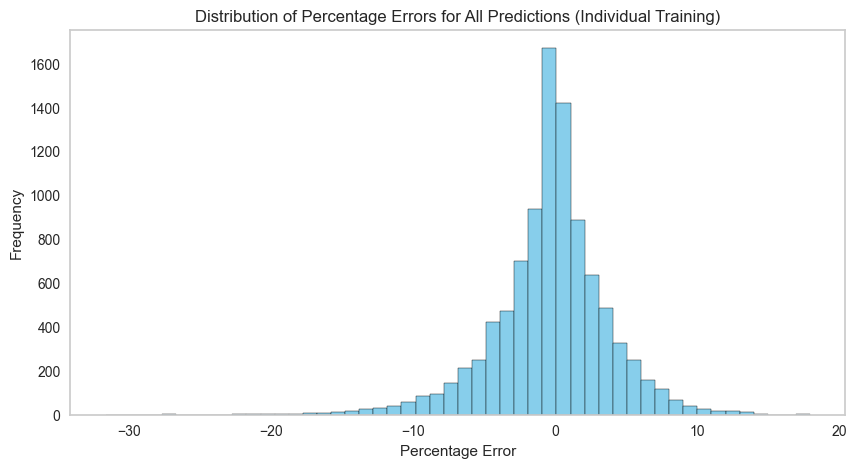

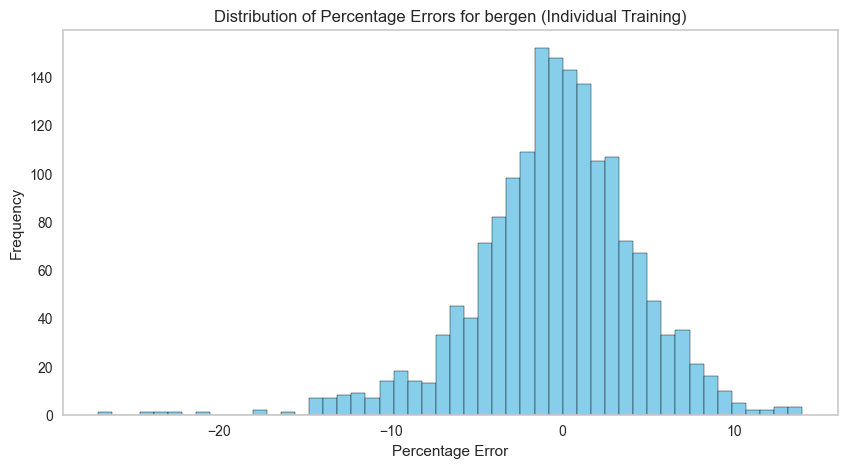

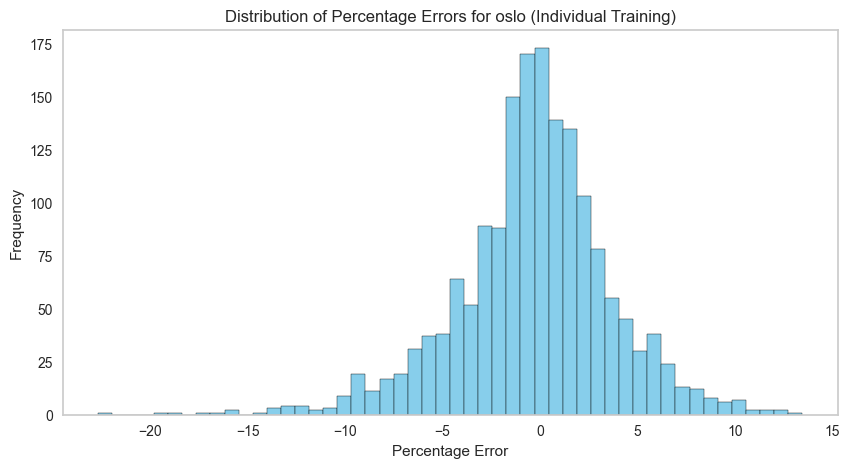

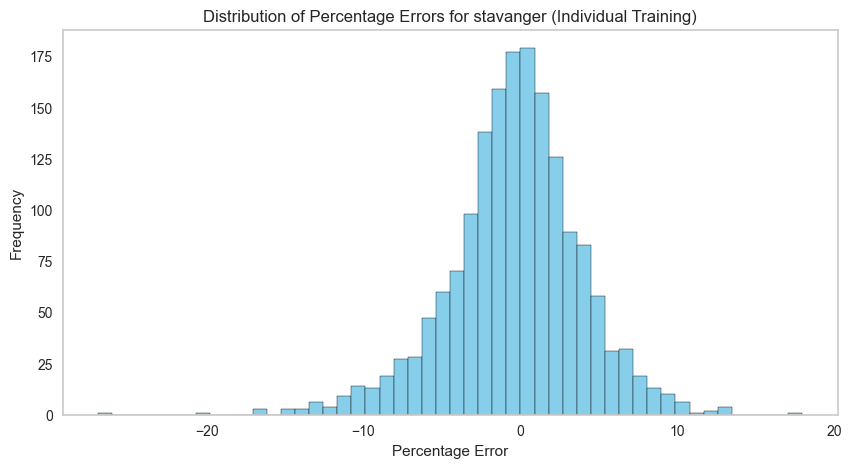

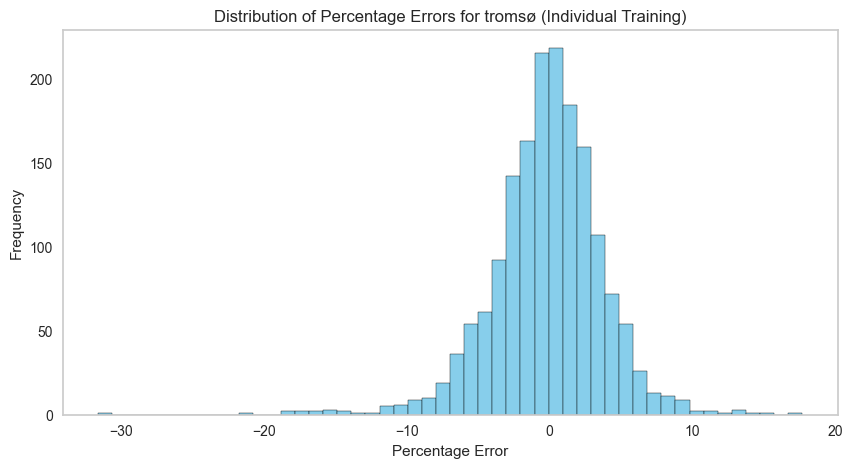

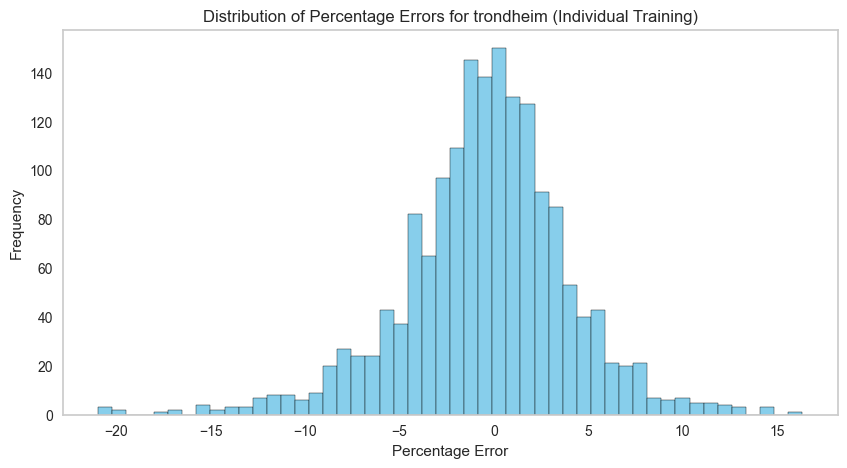

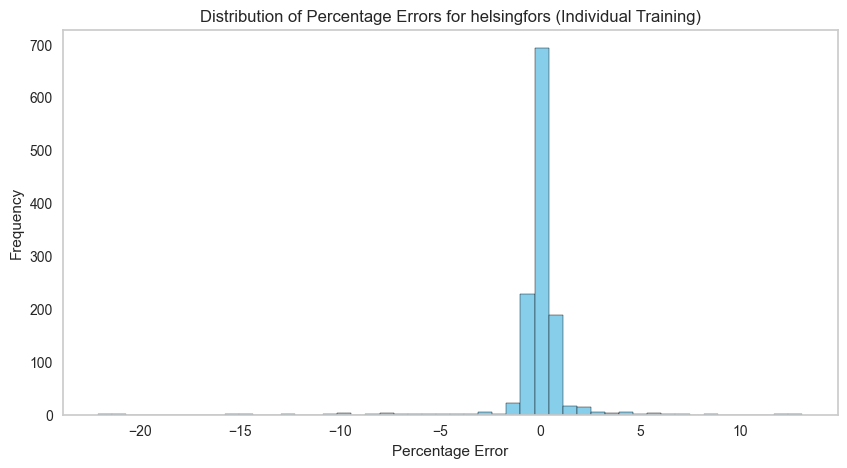

In [36]:
import matplotlib.pyplot as plt

# Function to calculate percentage errors
def calculate_percentage_errors(true_values, predicted_values):
    return ((true_values - predicted_values) / true_values) * 100

# Calculate percentage errors for all predictions combined
all_percentage_errors_individual = []
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    percentage_errors = calculate_percentage_errors(combined_true, combined_predicted)
    all_percentage_errors_individual.extend(percentage_errors)

# Plot histogram of percentage errors for all predictions combined
plt.figure(figsize=(10, 5))
plt.hist(all_percentage_errors_individual, bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Percentage Errors for All Predictions (Individual Training)')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Plot histogram of percentage errors for each location
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    percentage_errors = calculate_percentage_errors(combined_true, combined_predicted)
    
    plt.figure(figsize=(10, 5))
    plt.hist(percentage_errors, bins=50, edgecolor='black', color='skyblue')
    plt.title(f'Distribution of Percentage Errors for {location} (Individual Training)')
    plt.xlabel('Percentage Error')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


In [37]:
import plotly.graph_objects as go

combined_individual_predictions = {}
for location in results_0_10.keys():
    combined_df = pd.concat([results_0_10[location], results_11_24[location]])
    combined_df = combined_df.sort_values(by='time')
    combined_individual_predictions[location] = combined_df


# Plot the results for each location
for location, subset_df in combined_individual_predictions.items():

    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    errors = true_values - predicted_values
    absolute_percentage_errors = (np.abs(true_values - predicted_values) / true_values) * 100


    fig = go.Figure()

    # Add traces for true values, predicted values, and absolute percentage errors
    fig.add_trace(go.Scatter(x=time, y=true_values, mode='lines', name='True Values'))
    fig.add_trace(go.Scatter(x=time, y=predicted_values, mode='lines', name='Predicted Values'))

    # Update layout for better visualization
    fig.update_layout(
        title=f'Predicted and True Values over Time for {location}',
        xaxis_title='Time',
        yaxis_title='Values',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            type="date"
        ),
        showlegend=True
    )

    fig.show()




